##  Study to maximize revenue from direct marketing campaigns

### Data

1. Social-demographical data (age, gender, tenure in a bank)
2. Products owned + actual volumes (current account, saving account, mutual funds, overdraft, credit card, consumer loan)
3. Inflow/outflow on C/A, aggregated card turnover (monthly average over past 3 months)
4. For 60 % of clients actual sales + revenues from these are available (training set)

### Tasks

1. Find out potential customers to offer them different products such as Consumer Loan (CL), Credit Card (CC) and Mutual Fund (MF)
2. Calculate expected revenue based on the findings from Task 1

### Importing different libraries and loading dataset (from .xls file containing 4 worksheets) stored in S3

In [1]:
import boto3
import pandas as pd
from sagemaker import get_execution_role
import seaborn as sns
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

role = get_execution_role()
bucket='kbcjob'
data_key = 'Task_Data_Scientist_Dataset.xlsx'
data_location = 's3://{}/{}'.format(bucket, data_key)
xls = pd.ExcelFile(data_location)
xls.sheet_names

['Description',
 'Soc_Dem',
 'Products_ActBalance',
 'Inflow_Outflow',
 'Sales_Revenues']

### Storing .xls worksheets in Pandas Dataframe object

### Data Preprocessing
1. Filling all NaN entries in Product Active Balance with zero 
2. Filling all NaN entries in Inflow and Outflow with zero

In [2]:
Soc_Dem = pd.read_excel(data_location, sheet_name='Soc_Dem')
Products_ActBalance = pd.read_excel(data_location, sheet_name='Products_ActBalance')
Products_ActBalance.fillna(0, inplace=True)
Inflow_Outflow = pd.read_excel(data_location, sheet_name='Inflow_Outflow')
Inflow_Outflow.fillna(0, inplace=True)
Sales_Revenues = pd.read_excel(data_location, sheet_name='Sales_Revenues')

### Checking null value count in Soc_Dem

In [3]:
Soc_Dem.isnull().sum()

Client    0
Sex       3
Age       0
Tenure    0
dtype: int64

### Filling NaN values in Sex column with 'M' because 'M' is a mode here

In [4]:
Soc_Dem['Sex'] = Soc_Dem['Sex'].fillna('M')

### 1615 Clients' social-demographical data is available

In [5]:
Soc_Dem.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Client,1615.0,808.000000,466.354658,1.0,404.5,808.0,1211.5,1615.0
Age,1615.0,42.848916,18.550529,0.0,29.0,41.0,57.0,97.0
Tenure,1615.0,101.339938,64.917297,0.0,44.0,97.0,151.0,273.0


### Some fields in Age are not practical (e.g. 0, 1). Lower bound set for Age as 16

In [6]:
Soc_Dem.loc[Soc_Dem['Age'] < 16.0, 'Age'] = 16.0

### 1615 Clients' data availalbe for Products owned + actual volumes

In [7]:
Products_ActBalance.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Client,1615.0,808.000000,466.354658,1.000000,404.500000,808.000000,1211.500000,1615.000000
Count_CA,1615.0,1.078638,0.333035,1.000000,1.000000,1.000000,1.000000,4.000000
Count_SA,1615.0,0.307740,0.567639,0.000000,0.000000,0.000000,1.000000,5.000000
Count_MF,1615.0,0.886068,3.871786,0.000000,0.000000,0.000000,0.000000,79.000000
Count_OVD,1615.0,0.259443,0.438465,0.000000,0.000000,0.000000,1.000000,1.000000
Count_CC,1615.0,0.105263,0.306987,0.000000,0.000000,0.000000,0.000000,1.000000
Count_CL,1615.0,0.099071,0.360837,0.000000,0.000000,0.000000,0.000000,5.000000
ActBal_CA,1615.0,2438.601941,7072.777350,0.000000,61.562143,462.221786,2174.864286,171575.889643
ActBal_SA,1615.0,4009.812781,17909.061545,0.000000,0.000000,0.000000,0.010000,389883.830714
ActBal_MF,1615.0,3887.532659,34868.010169,0.000000,0.000000,0.000000,0.000000,761235.504286


### Creating Data_Set by Merging social-demographical data with Products owned + actual volumes

In [8]:
Data_Set = Soc_Dem.merge(Products_ActBalance, on = 'Client', how = "outer")

### Check for null values after merging

In [9]:
Data_Set.isnull().sum()

Client        0
Sex           0
Age           0
Tenure        0
Count_CA      0
Count_SA      0
Count_MF      0
Count_OVD     0
Count_CC      0
Count_CL      0
ActBal_CA     0
ActBal_SA     0
ActBal_MF     0
ActBal_OVD    0
ActBal_CC     0
ActBal_CL     0
dtype: int64

### Creating Training_Data by merging Salse_Revenues and Inflow/Outflow on 'Client'

In [10]:
Training_Data = Data_Set.merge(Sales_Revenues, on = 'Client', how = "inner")
Training_Data = Training_Data.merge(Inflow_Outflow, on = 'Client', how = "left")

### Training_Data contains data of 969 Clients who are already using one or more products

In [11]:
Training_Data.shape

(969, 36)

### Check for null values after merging

In [12]:
Training_Data.isnull().sum()

Client                           0
Sex                              0
Age                              0
Tenure                           0
Count_CA                         0
Count_SA                         0
Count_MF                         0
Count_OVD                        0
Count_CC                         0
Count_CL                         0
ActBal_CA                        0
ActBal_SA                        0
ActBal_MF                        0
ActBal_OVD                       0
ActBal_CC                        0
ActBal_CL                        0
Sale_MF                          0
Sale_CC                          0
Sale_CL                          0
Revenue_MF                       0
Revenue_CC                       0
Revenue_CL                       0
VolumeCred                      18
VolumeCred_CA                   18
TransactionsCred                18
TransactionsCred_CA             18
VolumeDeb                       18
VolumeDeb_CA                    18
VolumeDebCash_Card  

### Data Preprocessing
1. Filling all NaN entries with Zero

In [13]:
Training_Data.fillna(0, inplace=True)

In [14]:
Training_Data.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
Client,1217,850,1473,1038,225,827,1231,739,956,1219
Sex,M,F,M,M,M,M,F,M,M,M
Age,38,49,54,29,16,57,16,69,52,33
Tenure,165,44,34,106,187,50,232,55,139,19
Count_CA,1,1,1,1,1,1,1,1,2,1
Count_SA,0,0,1,0,0,0,0,1,0,0
Count_MF,0,0,0,0,0,0,0,8,0,0
Count_OVD,0,0,0,0,1,1,0,1,1,0
Count_CC,0,0,1,0,0,1,0,0,0,0
Count_CL,0,0,1,0,0,0,0,1,0,0


### Creating Test_Data by merging Salse_Revenues and Inflow/Outflow for the Clients who are not using any of the products  

#### Note: Test_Data contains data of 646 Clients who are not using any of the product (originally having NaN values in Sales_Revenue)

In [15]:
Test_Data = Data_Set.merge(Sales_Revenues, on = 'Client', how = "outer")
is_NaN = Test_Data.isnull()
row_has_NaN = is_NaN.any(axis=1)
Test_Data = Test_Data[row_has_NaN]
Test_Data = Test_Data.merge(Inflow_Outflow, on = 'Client', how = "left")
Test_Data.shape

(646, 36)

In [16]:
Test_Data.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
Client,909,699,528,1145,517,1475,175,1134,1218,7
Sex,M,M,F,M,F,F,F,F,F,F
Age,21,37,19,61,41,59,41,35,36,55
Tenure,27,175,70,45,28,20,61,96,49,227
Count_CA,1,1,1,1,1,1,1,1,1,1
Count_SA,0,0,0,0,0,0,0,0,1,0
Count_MF,0,4,0,0,0,0,0,0,0,0
Count_OVD,1,1,1,0,0,0,0,1,0,0
Count_CC,0,0,0,0,0,0,0,0,0,0
Count_CL,1,0,0,0,0,0,2,1,0,0


### Skew Analysis (969 Clients who are using one or more products)

In [17]:
check_sale = pd.DataFrame({'Product': {0: 'Credit Card', 1: 'Consumer Loan',2:'Mutual Fund'}, 
                           'Total Customers': {0: float(Training_Data[["Sale_CC"]].sum()),
                          1:float(Training_Data[["Sale_CL"]].sum()),
                          2:float(Training_Data[["Sale_MF"]].sum()) }})

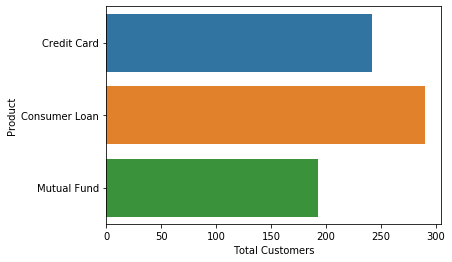

In [18]:
sns.barplot(x = 'Total Customers', y = 'Product', data = check_sale)

## Consumer Loan
### Training_Data_CL is a dataset for training of model to identify potential customers for Conusmer Loan

In [19]:
Training_Data_CL = Training_Data.drop(['Sale_CC', 'Sale_MF', 'Revenue_MF', 'Revenue_CL', 'Revenue_CC'], 
                                      axis=1)
Training_Data_CL.Sex = (Training_Data_CL.Sex == 'M')
Training_Data_CL.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1217,True,38.0,165,1,0.0,0.0,0.0,0.0,0.0,...,714.285714,714.285714,0.000000,0.000000,714.285714,1.0,1.0,0.0,0.0,1.0
1,850,False,49.0,44,1,0.0,0.0,0.0,0.0,0.0,...,1226.345357,1226.345357,0.000000,0.000000,121.928571,6.0,6.0,0.0,0.0,1.0
2,1473,True,54.0,34,1,1.0,0.0,0.0,1.0,1.0,...,3875.137857,3794.580714,357.142857,444.597500,2076.785714,48.0,38.0,1.0,26.0,11.0
3,1038,True,29.0,106,1,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,225,True,16.0,187,1,0.0,0.0,1.0,0.0,0.0,...,130.521429,130.521429,0.000000,111.235714,19.285714,5.0,5.0,0.0,4.0,1.0


### Validation split set to be 0.2

In [20]:
X_CL = Training_Data_CL.drop(['Sale_CL'], axis=1)
Y_CL = Training_Data_CL['Sale_CL']
trainCL_X, testCL_X, trainCL_y, testCL_y = train_test_split(X_CL, Y_CL, test_size=0.2, random_state=0)

In [21]:
trainCL_X_1 = trainCL_X.iloc[:,1:]
testCL_X_1 = testCL_X.iloc[:,1:]

### Training Gradient Boosting Classifier to predict if a client can buy Consumer Loan

In [22]:
model_CL = GradientBoostingClassifier()
model_CL.fit(trainCL_X_1,trainCL_y)
y_pred_CL=model_CL.predict(testCL_X_1)

In [23]:
print("Accuracy:",metrics.accuracy_score(testCL_y, y_pred_CL))
print("f1 score:",metrics.f1_score(testCL_y, y_pred_CL))
print("roc auc score:",metrics.roc_auc_score(testCL_y, y_pred_CL))

Accuracy: 0.788659793814433
f1 score: 0.481012658227848
roc auc score: 0.6557177615571776


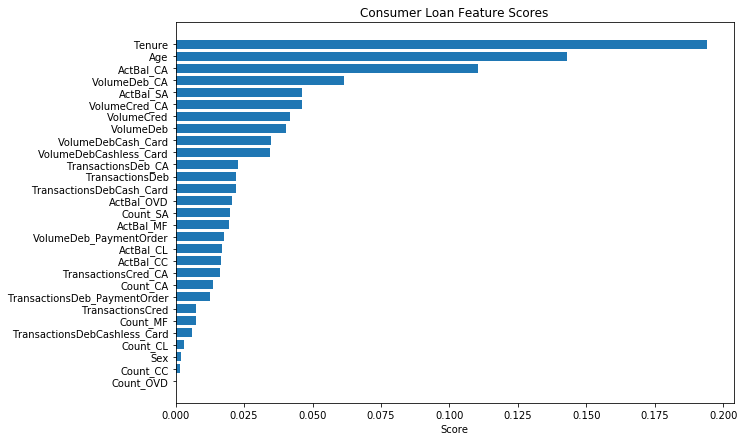

In [24]:
CL_imp = pd.DataFrame({'Feature':trainCL_X_1.columns,
                          'Feature Score': model_CL.feature_importances_})
CL_imp = CL_imp.sort_values(by=['Feature Score'])

plt.figure(figsize=(10,7))
plt.barh(CL_imp['Feature'], CL_imp['Feature Score'])
plt.title('Consumer Loan Feature Scores')
plt.xlabel('Score')
plt.show()

### 22 potential clients found to be offered with Consumer Loan

In [25]:
Target_CL = pd.DataFrame(data=testCL_X)
Target_CL['pred'] = y_pred_CL
Target_CL[Target_CL['pred'] == 1]['Client'].count()

22

### Client ID for potential clients for Consumer Loan are given Below:

In [26]:
Target_CL[Target_CL['pred'] == 1]['Client']

458    1564
379     900
736     808
358     672
310     102
466     838
270     642
794     348
366     557
77       82
669     990
362     491
828     961
576    1583
729    1259
865     775
520     873
345    1220
670    1513
651    1333
154    1236
278     558
Name: Client, dtype: int64

## Credit Card
### Training_Data_CC is a dataset for training of model to identify potential customers for Credit Card

In [27]:
Training_Data_CC = Training_Data.drop(['Sale_CL', 'Sale_MF', 'Revenue_MF', 'Revenue_CL', 'Revenue_CC'], axis=1)
Training_Data_CC.Sex = (Training_Data_CC.Sex == 'M')
Training_Data_CC.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1217,True,38.0,165,1,0.0,0.0,0.0,0.0,0.0,...,714.285714,714.285714,0.000000,0.000000,714.285714,1.0,1.0,0.0,0.0,1.0
1,850,False,49.0,44,1,0.0,0.0,0.0,0.0,0.0,...,1226.345357,1226.345357,0.000000,0.000000,121.928571,6.0,6.0,0.0,0.0,1.0
2,1473,True,54.0,34,1,1.0,0.0,0.0,1.0,1.0,...,3875.137857,3794.580714,357.142857,444.597500,2076.785714,48.0,38.0,1.0,26.0,11.0
3,1038,True,29.0,106,1,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,225,True,16.0,187,1,0.0,0.0,1.0,0.0,0.0,...,130.521429,130.521429,0.000000,111.235714,19.285714,5.0,5.0,0.0,4.0,1.0


### Validation split set to be 0.2

In [28]:
X_CC = Training_Data_CC.drop(['Sale_CC'], axis=1)
Y_CC = Training_Data_CC['Sale_CC']
trainCC_X, testCC_X, trainCC_y, testCC_y = train_test_split(X_CC, Y_CC, test_size=0.2, random_state=0)

In [29]:
trainCC_X_1 = trainCC_X.iloc[:,1:]
testCC_X_1 = testCC_X.iloc[:,1:]

### Training Gradient Boosting Classifier to predict if a client can buy Credit Card

In [30]:
model_CC = GradientBoostingClassifier(learning_rate=0.01, n_estimators=200)
model_CC.fit(trainCC_X_1,trainCC_y)
y_pred_CC=model_CC.predict(testCC_X_1)

In [31]:
print("Accuracy:",metrics.accuracy_score(testCC_y, y_pred_CC))
print("f1 score:",metrics.f1_score(testCC_y, y_pred_CC))
print("roc auc score:",metrics.roc_auc_score(testCC_y, y_pred_CC))

Accuracy: 0.7783505154639175
f1 score: 0.21818181818181817
roc auc score: 0.5515151515151515


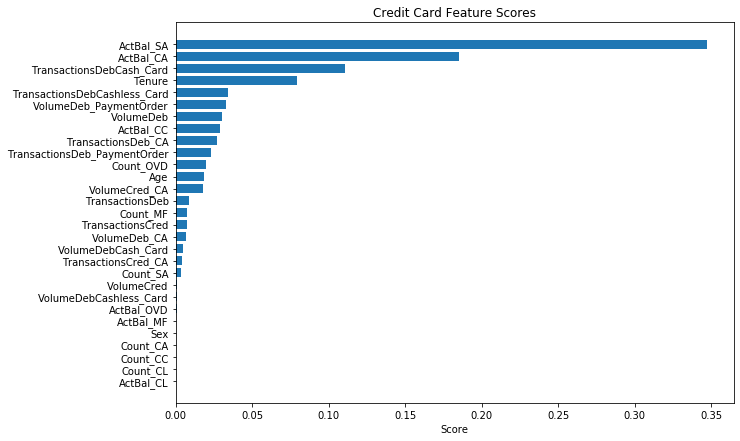

In [32]:
CC_imp = pd.DataFrame({'Feature':trainCC_X_1.columns,
                          'Feature Score': model_CC.feature_importances_})
CC_imp = CC_imp.sort_values(by=['Feature Score'])

plt.figure(figsize=(10,7))
plt.barh(CC_imp['Feature'], CC_imp['Feature Score'])
plt.title('Credit Card Feature Scores')
plt.xlabel('Score')
plt.show()

### 11 potential clients found to be offered with Credit Card

In [33]:
Target_CC = pd.DataFrame(data=testCC_X)
Target_CC['pred'] = y_pred_CC
Target_CC[Target_CC['pred'] == 1]['Client'].count()

11

### Client ID for potential clients for Credit Card are given Below:

In [34]:
Target_CC[Target_CC['pred'] == 1]['Client']

298    1344
577     344
97     1036
351      21
413     219
642     721
311     734
345    1220
306    1529
875    1044
767    1408
Name: Client, dtype: int64

## Mutual Fund
### Training_Data_MF is a dataset for training of model to identify potential customers for Mutual Fund

In [35]:
Training_Data_MF = Training_Data.drop(['Sale_CL', 'Sale_CC', 'Revenue_MF', 'Revenue_CL', 'Revenue_CC'], axis=1)
Training_Data_MF.Sex = (Training_Data_MF.Sex == 'M')
Training_Data_MF.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1217,True,38.0,165,1,0.0,0.0,0.0,0.0,0.0,...,714.285714,714.285714,0.000000,0.000000,714.285714,1.0,1.0,0.0,0.0,1.0
1,850,False,49.0,44,1,0.0,0.0,0.0,0.0,0.0,...,1226.345357,1226.345357,0.000000,0.000000,121.928571,6.0,6.0,0.0,0.0,1.0
2,1473,True,54.0,34,1,1.0,0.0,0.0,1.0,1.0,...,3875.137857,3794.580714,357.142857,444.597500,2076.785714,48.0,38.0,1.0,26.0,11.0
3,1038,True,29.0,106,1,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,225,True,16.0,187,1,0.0,0.0,1.0,0.0,0.0,...,130.521429,130.521429,0.000000,111.235714,19.285714,5.0,5.0,0.0,4.0,1.0


### Validation split set to be 0.2

In [36]:
X_MF = Training_Data_MF.drop(['Sale_MF'], axis=1)
Y_MF = Training_Data_MF['Sale_MF']
trainMF_X, testMF_X, trainMF_y, testMF_y = train_test_split(X_MF, Y_MF, test_size=0.2, random_state=0)

In [37]:
trainMF_X_1 = trainMF_X.iloc[:,1:]
testMF_X_1 = testMF_X.iloc[:,1:]

### Training Hist Gradient Boosting Classifier to predict if a client can buy Mutual Fund

In [38]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
model_MF = HistGradientBoostingClassifier()
model_MF.fit(trainMF_X_1,trainMF_y)
y_pred_MF=model_MF.predict(testMF_X_1)

In [39]:
print("Accuracy:",metrics.accuracy_score(testMF_y, y_pred_MF))
print("f1 score:",metrics.f1_score(testMF_y, y_pred_MF))
print("roc auc score:",metrics.roc_auc_score(testMF_y, y_pred_MF))

Accuracy: 0.7731958762886598
f1 score: 0.21428571428571427
roc auc score: 0.5481818181818181


### 12 potential clients found to be offered with Mutual Fund

In [40]:
Target_MF = pd.DataFrame(data=testMF_X)
Target_MF['pred'] = y_pred_MF
Target_MF[Target_MF['pred'] == 1]['Client'].count()

12

### Client ID for potential clients for Mutual Fund are given Below:

In [41]:
Target_MF[Target_MF['pred'] == 1]['Client']

308      78
55      478
871    1040
266    1581
366     557
175     291
103     981
27      416
692    1091
283    1613
443    1055
332     989
Name: Client, dtype: int64

## Expected Revenue

### Consumer Loan
1. Training Dataset was created
2. Validation Split set to be 0.2
3. Linear Regression model was trained
4. Revenue was predicted from the potential clients found in the previous section

In [42]:
Training_Data_CL_Rev = Training_Data.drop(['Sale_CL', 'Sale_CC', 'Sale_MF', 'Revenue_MF', 'Revenue_CC'], axis=1)
Training_Data_CL_Rev.Sex = (Training_Data_CL_Rev.Sex == 'M')
Training_Data_CL_Rev = Training_Data_CL_Rev[(Training_Data_CL_Rev['Revenue_CL'] != 0.00)]
X_CL_Rev = Training_Data_CL_Rev.drop(['Revenue_CL'], axis=1)
Y_CL_Rev = Training_Data_CL_Rev['Revenue_CL']
trainCL_X_Rev, testCL_X_Rev, trainCL_y_Rev, testCL_y_Rev = train_test_split(X_CL_Rev, 
                                                                            Y_CL_Rev, test_size=0.2, random_state=0)
trainCL_X_1_Rev = trainCL_X_Rev.iloc[:,1:]
testCL_X_1_Rev = testCL_X_Rev.iloc[:,1:]

In [43]:
model_CL_Rev = LinearRegression()
model_CL_Rev.fit(trainCL_X_1_Rev,trainCL_y_Rev)
y_pred_CL_Rev=model_CL_Rev.predict(testCL_X_1_Rev)
print("Mean absolute error:",metrics.mean_absolute_error(testCL_y_Rev, y_pred_CL_Rev))

Mean absolute error: 13.143207372245323


In [44]:
Expected_CL_Rev = Target_CL[Target_CL['pred'] == 1]
Expected_CL_Rev = Expected_CL_Rev.drop(['pred', 'Client'], axis = 1)
CL_Rev=model_CL_Rev.predict(Expected_CL_Rev)
print("Expected Revenue from Consumer Loan:",CL_Rev.sum())

Expected Revenue from Consumer Loan: 314.4808534689849


### Credit Card
1. Training Dataset was created
2. Validation Split set to be 0.2
3. Linear Regression model was trained
4. Revenue was predicted from the potential clients found in the previous section

In [45]:
Training_Data_CC_Rev = Training_Data.drop(['Sale_CL', 'Sale_CC', 'Sale_MF', 'Revenue_MF', 'Revenue_CL'], axis=1)
Training_Data_CC_Rev.Sex = (Training_Data_CC_Rev.Sex == 'M')
Training_Data_CC_Rev = Training_Data_CC_Rev[(Training_Data_CC_Rev['Revenue_CC'] != 0.00)]
X_CC_Rev = Training_Data_CC_Rev.drop(['Revenue_CC'], axis=1)
Y_CC_Rev = Training_Data_CC_Rev['Revenue_CC']
trainCC_X_Rev, testCC_X_Rev, trainCC_y_Rev, testCC_y_Rev = train_test_split(X_CC_Rev, Y_CC_Rev, 
                                                                            test_size=0.2, random_state=0)
trainCC_X_1_Rev = trainCC_X_Rev.iloc[:,1:]
testCC_X_1_Rev = testCC_X_Rev.iloc[:,1:]

In [46]:
model_CC_Rev = LinearRegression()
model_CC_Rev.fit(trainCC_X_1_Rev,trainCC_y_Rev)
y_pred_CC_Rev=model_CC_Rev.predict(testCC_X_1_Rev)
print("Mean absolute error:",metrics.mean_absolute_error(testCC_y_Rev, y_pred_CC_Rev))

Mean absolute error: 16.981163515467877


In [47]:
Expected_CC_Rev = Target_CC[Target_CC['pred'] == 1]
Expected_CC_Rev = Expected_CC_Rev.drop(['pred', 'Client'], axis = 1)
CC_Rev=model_CC_Rev.predict(Expected_CC_Rev)
print("Expected Revenue from Credit Card:",CC_Rev.sum())

Expected Revenue from Credit Card: 25.08965348211682


### Mutual Fund
1. Training Dataset was created
2. Validation Split set to be 0.2
3. Linear Regression model was trained
4. Revenue was predicted from the potential clients found in the previous section

In [48]:
Training_Data_MF_Rev = Training_Data.drop(['Sale_CL', 'Sale_CC', 'Sale_MF', 'Revenue_CL', 'Revenue_CC'], axis=1)
Training_Data_MF_Rev.Sex = (Training_Data_MF_Rev.Sex == 'M')
Training_Data_MF_Rev = Training_Data_MF_Rev[(Training_Data_MF_Rev['Revenue_MF'] != 0.00)]
X_MF_Rev = Training_Data_MF_Rev.drop(['Revenue_MF'], axis=1)
Y_MF_Rev = Training_Data_MF_Rev['Revenue_MF']
trainMF_X_Rev, testMF_X_Rev, trainMF_y_Rev, testMF_y_Rev = train_test_split(X_MF_Rev, Y_MF_Rev, 
                                                                            test_size=0.2, random_state=0)
trainMF_X_1_Rev = trainMF_X_Rev.iloc[:,1:]
testMF_X_1_Rev = testMF_X_Rev.iloc[:,1:]

In [49]:
model_MF_Rev = LinearRegression()
model_MF_Rev.fit(trainMF_X_1_Rev,trainMF_y_Rev)
y_pred_MF_Rev=model_MF_Rev.predict(testMF_X_1_Rev)
print("Mean absolute error:",metrics.mean_absolute_error(testMF_y_Rev, y_pred_MF_Rev))

Mean absolute error: 18.558030898383038


In [50]:
Expected_MF_Rev = Target_MF[Target_MF['pred'] == 1]
Expected_MF_Rev = Expected_MF_Rev.drop(['pred', 'Client'], axis = 1)
MF_Rev=model_MF_Rev.predict(Expected_MF_Rev)
print("Expected Revenue from Mutual Fund:",MF_Rev.sum())

Expected Revenue from Mutual Fund: 196.05616006323956


## Total Expected Revenue

In [51]:
Total_Rev = MF_Rev.sum() + CC_Rev.sum() + CL_Rev.sum()
print("Total Expected Revenue:",Total_Rev)

Total Expected Revenue: 535.6266670143413
